In [13]:
import tifffile
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, EarlyStopping

from tensorflow.keras.optimizers import SGD, Adam


from models import *
from utils import *
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
#import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

"""
key simulation parameters (begin)
##############################################################################
"""
combomatrix = [128, 128, 64, 64, 64, 32, 9, 100, 100, 64, False]
'''
 in form [blksz_3d[0],           block size in row direction (pixel units)
             blksz_3d[1],           block size in column direction (pixel units)
             blksz_3d[2],           block size in slice direction (pixel units)
             stride_3d[0],          stride of block selection in row direction (pixel units)
             stride_3d[1],          stride of block selection in column direction (pixel units)
             stride_3d[2],          stride of block selection in slice direction (pixel units)
             patch_select_mode,     block selection mode (see compute_metric_volume_3d() function in utils.py)
             patches_per_set_h,     number of high signal/edge training blocks per volume
             patches_per_set_l,     number of low signal training blocks per volume
             unet_start_ch,         number of starting channels for the U-Net
             unet_resnet_mode]      residual learning mode for the U-Net to predict the difference; (default == False)
'''

# test mode options
testmode = False  # test by training/predicting the first case only for one reduction factor
testmode_epochs = False  # limits the number of epochs

# basic inputs/parameters
#reduction_list = [3] if testmode else [2, 3, 4, 5, 6]  # resolution reduction factors to train/predict
proj_direction = 0  # projection direction for training; 0: no projection, 1: lateral projection, 2: frontal projection
loss_function = 'ssim_loss'  # 'ssim_loss'
sleep_when_done = False if testmode else True  # sleep computer when finished
patches_from_volume = True  # False: patches selected from each slice; True: patches selected from whole volume
data_augm_factor = 1  # 1, 2, 4, or 8 are options for residual net
#data_augm_factor = set_augmentation_factor_for_3D_net(data_augm_factor)  # set augmentation factor to 1,2,4 or 8
optimizers = 'adam'  # ['adam', 'sgd']
leave_one_out_train = False  # performs training using a leave one out scheme
lr = 0.0001 #learning rate

Num GPUs Available:  0


In [14]:
#for b_index in combomatrix:  # loop over reconstructions to perform
# input channels for UNets
input_ch = combomatrix[2]

patch_select_mode = combomatrix[6]  # set patch selection mode
try:
    patches_per_set_h = combomatrix[7]  # set number of high intensity patches selected from each dataset
    patches_per_set_l = combomatrix[8]  # set number of random intensity patches selected from each dataset
except:
    patches_per_set_h = 500  # set number of high intensity patches selected from each dataset
    patches_per_set_l = 500  # set number of random intensity patches selected from each dataset
patches_per_set = patches_per_set_h + patches_per_set_l
try:
    unet_resnet_mode = combomatrix[10]
except:
    unet_resnet_mode = False

# construct folder name where models are
if loss_function == "mean_squared_error":
    foldersuffix = '_' + str(data_augm_factor) + 'aug_proj' + str(proj_direction) + 'psm' + str(
        patch_select_mode) + "_" + "mse"
else:
    foldersuffix = '_' + str(data_augm_factor) + 'aug_proj' + str(proj_direction) + 'psm' + str(
        patch_select_mode) + "_" + loss_function

#for optim in optimizers:  # loop through optimizers
nepochs = 2 if testmode_epochs else 200  # number of epochs to train for
batch_size_train = 20 #if b_index[0] == 32 else 32 // b_index[0] * 20

blksz_3d = combomatrix[0], combomatrix[1], combomatrix[2]  # block size in pixels that is used to train the model
stride_3d = combomatrix[3], combomatrix[4], combomatrix[5]  # stride size in pixels that is used to train the model

# U-net related inputs/parameters
try:
    unet_start_ch = combomatrix[9]
except:
    unet_start_ch = 16  # number of starting channels
unet_depth = 4 if combomatrix[0] ** 0.25 >= 2 else 3  # depth (i.e. # of max pooling steps)
unet_inc_rate = 2  # channel increase rate
unet_dropout = 0.5  # dropout rate
unet_batchnorm = False  # batch normalization mode
unet_residual = False  # residual connections mode
unet_batchnorm_str = 'F' if not unet_batchnorm else 'T'
unet_residual_str = 'F' if not unet_residual else 'T'

n_edge_after_proj = 0  # the edge images not used after proj_direction

blks_rand_shift_mode = False
training_patience = 3
n_slices_exclude = 4  # number of edge slices to not train from (default value is zero)

subset_train_mode = False  # flag that allows to only to train from a subset of slices from the full volume
subset_train_minslc = 1  # training subset mode - minimum slice
subset_train_maxslc = 500  # training subset mode - maximum slice

# factors for additional in-plane (i.e. x and y) cropping of volumes during training phase
crop_train_x = 1 #0.50 if patches_from_volume else 1
crop_train_y = 1 #0.50 if patches_from_volume else 0.6

###############################################################################
# find distinct data sets
###############################################################################
# script_path = os.path.split(os.path.abspath(__file__))[0]
script_path =os.getcwd()
dirtarget = os.path.join(script_path, "../../ARIC/pd_wip/wip_registration_nifti/train")
#dirsource = "data/train/CentreSquare15p25Mask"
dirsource = os.path.join(script_path, "../../ARIC/pd_wip/pd_nifti_final/train")
#dirtarget = "data/train/anat1"
try:
    srcfiles, tgtfiles = get_source_and_target_files(dirsource, dirtarget)
    srcfiles.sort()
    tgtfiles.sort()
    #select 10 for tiny training
    srcfiles=srcfiles[0:5]
    tgtfiles=tgtfiles[0:5]
    print("srcfiles size",len(srcfiles))
    print("tgtfiles size",len(tgtfiles))
except:
    print('could not find', reduction, 'source or target files so skipping')


srcfiles size 5
tgtfiles size 5


In [15]:
###############################################################################
# check if we've already trained the model; if no, train it, if yes, load it from disk
###############################################################################
rstr = "res" if unet_resnet_mode else ""
modelsuffix = "_unet3d" + rstr + "-" + "[" + str(stride_3d[0]) + 'x' + str(stride_3d[1]) + 'x' + str(
    stride_3d[2]) + "]-psm" + str(patch_select_mode) + "-" + str(unet_start_ch) + "-" + str(
    unet_depth) + "-" + str(unet_inc_rate) + "-" + str(
    unet_dropout) + "-" + unet_batchnorm_str + "-" + unet_residual_str + '-batch' + str(batch_size_train)
modelprefix = "model_" + str(blksz_3d[0]) + "x" + str(blksz_3d[1]) + "x" + str(blksz_3d[2]) + "x" + str(
    patches_per_set) + "(" + str(patches_per_set_h) + ")(" + str(patches_per_set_l) + ")x" + str(
    data_augm_factor)

# check if we need to train more models and set the training_needed_flag, as well as return the list for leave one out training mode
outpath = 'train_' + 'unet3d' + rstr + '_' + optimizers  + '_batch' + str(
    batch_size_train) + foldersuffix

#script_path = os.path.split(os.path.abspath(__file__))[0]
dirmodel = os.path.join(script_path, outpath)
if not os.path.exists(dirmodel):
    os.makedirs(dirmodel)

training_needed_flag = should_we_train_network(
    os.path.join(dirmodel, modelprefix + modelsuffix), srcfiles)

couldn't find  /Users/meililiu/Desktop/Course/medical_image/code/super-pd-wip/train_unet3d_adam_batch20_1aug_proj0psm9_ssim_loss/model_128x128x64x200(100)(100)x1_unet3d-[64x64x32]-psm9-64-4-2-0.5-F-F-batch20.json


In [16]:
if training_needed_flag:
    print("model not found for sets", " so must train it")
                ###############################################################################
# create training data if not already created
                ###############################################################################
    suffix_npy = "_unet3d" + rstr + "_3dto3d_" + str(blksz_3d[0]) + "x" + str(blksz_3d[1]) + "x" + str(
        blksz_3d[2]) + "_" + str(patches_per_set) + "(" + str(patches_per_set_h) + ")(" + str(
        patches_per_set_l) + ")"  + "_psm" + str(
        patch_select_mode)
    if not os.path.exists(os.path.join(script_path, 'xtrain_master_noaug' + suffix_npy + '.npy')):
        print("training data not found, so must create it")
                    ###############################################################################
#create training arrays
                    ###############################################################################
        totalpatches = len(srcfiles) * patches_per_set

        xtrain_master_noaug = np.zeros([totalpatches, blksz_3d[0], blksz_3d[1], input_ch, 1],
                                       dtype=np.float32)
        ytrain_master_noaug = np.zeros([totalpatches, blksz_3d[0], blksz_3d[1], input_ch, 1],
                                       dtype=np.float32)

                    # count the number of total slices to learn from during training phase (i.e. loop through all data sets except the one that is being reconstructed)
        slice_count = 0  # counter holding number of slices incorporated into training
                    ###############################################################################
        # load .npy files from disk, display central coronal slice, and fill xtrain and ytrain matrices
                    ###############################################################################
        slices_per_file = []  # recording the number of slices used for training data extractions
        if proj_direction > 0:
            n_slices_exclude = n_edge_after_proj

        for m, icode in enumerate(srcfiles):  # loop over volumes to train from
            print('##############################################')
            print('pd file is =>', icode)
            ###################################
            # load numpy arrays, reproject dataset (if needed) and trim and normalize dataset,
            ###################################
            volume1, volume1max = load_tiff_volume_and_scale_si(dirsource, icode, crop_train_x,
                                                                crop_train_y, blksz_3d[:2], proj_direction,
                                                                subset_train_mode, subset_train_minslc,
                                                                subset_train_maxslc)

            print('wid is =>', tgtfiles[m])
            volume3, volume3max = load_tiff_volume_and_scale_si(dirtarget, tgtfiles[m], crop_train_x,
                                                                crop_train_y, blksz_3d[:2], proj_direction,
                                                                subset_train_mode, subset_train_minslc,
                                                                subset_train_maxslc)
            # prepare training data for 3D Unet or 3D Residual net
            # 3D Unet
            # create metric volume used to select blocks
            vol_metric, metric_operator, nregions = compute_metric_volume_3d(volume1, volume3,
                                                                             patch_select_mode, stride_3d)
                        # create the training input (xtrain_master...) and output (ytrain_master...) 3D blocks
            if not unet_resnet_mode:
                xtrain_master_noaug[m * patches_per_set:(m + 1) * patches_per_set, :, :, :,
                0], ytrain_master_noaug[m * patches_per_set:(m + 1) * patches_per_set, :, :, :,
                    0], blockvolmap = get_blocks_within_volume(vol_metric, [volume1, volume3], blksz_3d,
                                                               stride_3d, patches_per_set_h,
                                                               n_lower=patches_per_set_l, seed=m,
                                                               shuffleP=blks_rand_shift_mode,
                                                               metric_operator=metric_operator,
                                                               nregions=nregions, return_bvm=True)
            else:
                xtrain_master_noaug[m * patches_per_set:(m + 1) * patches_per_set, :, :, :,
                0], ytrain_master_noaug[m * patches_per_set:(m + 1) * patches_per_set, :, :, :,
                    0], blockvolmap = get_blocks_within_volume(vol_metric,
                                                               [volume1, volume3 - volume1],
                                                               blksz_3d,
                                                               stride_3d,
                                                               n_larger=patches_per_set_h,
                                                               n_lower=patches_per_set_l,
                                                               seed=m,
                                                               shuffleP=blks_rand_shift_mode,
                                                               metric_operator=metric_operator,
                                                               nregions=nregions,
                                                               return_bvm=True)
            print(np.amax(blockvolmap), np.amin(blockvolmap))
            blockvolmap = np.uint16(np.round(
                np.float(volume3max / np.amax(blockvolmap)) * np.moveaxis(blockvolmap, -1,
                                                                          0)))  # move slices from 3rd dimension to 1st dimension
            tifffile.imsave(
                'blockvolmap' + suffix_npy + '_' + str(m) + "_" + str(nregions) + "regions.tiff",
                blockvolmap, compress=6)
            slices_per_file.append(patches_per_set)
            print('train data fitted: m, m*patches_per_set:(m+1)*patches_per_set: ', m, m * patches_per_set,
                  (m + 1) * patches_per_set)

            if m == (len(srcfiles) - 1):  # if last volume, save the training data to disk
                np.save(os.path.join(script_path, 'xtrain_master_noaug' + suffix_npy), xtrain_master_noaug)
                np.save(os.path.join(script_path, 'ytrain_master_noaug' + suffix_npy), ytrain_master_noaug)

        print('total files read for training: ', len(srcfiles))
        print('total slices read for training: ', slice_count)
        print('unaugmented patch array size for training: ', xtrain_master_noaug.shape)
        print('slices (or blks) read from all the files: ', slices_per_file)
    ###############################################################################
    # load training data from disk if not already created
    ###############################################################################
    else:
        print("training data found, so just load it")
        # load numpy arrays
        xtrain_master_noaug = np.load(
            os.path.join(script_path, 'xtrain_master_noaug' + suffix_npy + '.npy'))
        ytrain_master_noaug = np.load(
            os.path.join(script_path, 'ytrain_master_noaug' + suffix_npy + '.npy'))
        print('loaded xtrain_master_noaug' + suffix_npy + '.npy' + ' shape: ', xtrain_master_noaug.shape)
        print('loaded ytrain_master_noaug' + suffix_npy + '.npy' + ' shape: ', ytrain_master_noaug.shape)
    print(" ")

    ###############################################################################
    #  flip the data in y, x, an z directions, augmenting by factors of 2, 4, or 8
    ###############################################################################
    if data_augm_factor >= 2:
        xtrain_master = np.concatenate(
            (xtrain_master_noaug, np.flip(xtrain_master_noaug, axis=1)))  # flip vertically (y)
        ytrain_master = np.concatenate((ytrain_master_noaug, np.flip(ytrain_master_noaug, axis=1)))
    if data_augm_factor >= 4:
        xtrain_master = np.concatenate(
            (xtrain_master, np.flip(xtrain_master, axis=2)))  # flip horizontally (x)
        ytrain_master = np.concatenate((ytrain_master, np.flip(ytrain_master, axis=2)))
    if data_augm_factor >= 8 and len(xtrain_master_noaug.shape) == 4:
        xtrain_master = np.concatenate((xtrain_master, np.flip(xtrain_master, axis=3)))  # flip over (z)
        ytrain_master = np.concatenate((ytrain_master, np.flip(ytrain_master, axis=3)))
    else:  # no augmentation
        ytrain_master = np.copy(ytrain_master_noaug)
        xtrain_master = np.copy(xtrain_master_noaug)

    shape_xtrain_master_noaug = xtrain_master_noaug.shape
    del ytrain_master_noaug
    del xtrain_master_noaug

    ###############################################################################
    # define model and print summary
    ###############################################################################

    n_loo_loops = 1  # only one network is trained for all data sets

    inds_all = np.arange(0, xtrain_master.shape[0] * data_augm_factor)

    print('using all data to train network')
    inds_to_train_from = np.copy(inds_all)
    xtrain = np.copy(xtrain_master[inds_to_train_from, :, :, :])
    ytrain = np.copy(ytrain_master[inds_to_train_from, :, :, :])

    ###############################################################################
    # define model and print summary
    ###############################################################################
    try:
        del model
    except:
        pass
    # 3D Unet
    model = unet3d((blksz_3d[0], blksz_3d[1], blksz_3d[2], 1),
                   out_ch=input_ch,
                   start_ch=unet_start_ch,
                   depth=unet_depth,
                   inc_rate=unet_inc_rate,
                   activation="relu",
                   dropout=unet_dropout,
                   batchnorm=unet_batchnorm,
                   maxpool=True,
                   upconv=False,
                   residual=unet_residual,
                   zdim=input_ch,
                   true_unet=True)
    print(model.summary())

    ###############################################################################
    # compile the model
    ###############################################################################
    
    opt = Adam(learning_rate=lr)
 
    if loss_function != 'ssim_loss':
        model.compile(loss=loss_function, optimizer=opt)
    else:
        model.compile(loss=ssim_loss, optimizer=opt, metrics=[ssim_loss, 'accuracy'])



model not found for sets  so must train it
training data found, so just load it
loaded xtrain_master_noaug_unet3d_3dto3d_128x128x64_200(100)(100)_psm9.npy shape:  (1000, 128, 128, 64, 1)
loaded ytrain_master_noaug_unet3d_3dto3d_128x128x64_200(100)(100)_psm9.npy shape:  (1000, 128, 128, 64, 1)
 
using all data to train network
(128, 128, 64, 1)
m KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 64, 1), dtype=tf.float32, name='input_3'), name='input_3', description="created by layer 'input_3'")
dim 64
m KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 32, 64), dtype=tf.float32, name=None), name='max_pooling3d_8/MaxPool3D:0', description="created by layer 'max_pooling3d_8'")
dim 128
m KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 16, 128), dtype=tf.float32, name=None), name='max_pooling3d_9/MaxPool3D:0', description="created by layer 'max_pooling3d_9'")
dim 256
m KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 8, 256), dtype=tf.float32, name=None), name='max_pool

                                256)                                                              
                                                                                                  
 conv3d_51 (Conv3D)             (None, 32, 32, 16,   10027264    ['conv3d_50[0][0]']              
                                256)                                                              
                                                                                                  
 conv3d_transpose_10 (Conv3DTra  (None, 64, 64, 32,   884864     ['conv3d_51[0][0]']              
 nspose)                        128)                                                              
                                                                                                  
 concatenate_10 (Concatenate)   (None, 64, 64, 32,   0           ['conv3d_41[0][0]',              
                                256)                              'conv3d_transpose_10[0][0]']    
          

In [17]:
xtrain.shape

(1000, 128, 128, 64, 1)

In [5]:
xtrain_master_noaug[1,:,:,0,0]

array([[0.299389  , 0.24439919, 0.27698573, ..., 0.16293278, 0.1364562 ,
        0.        ],
       [0.3503055 , 0.35845214, 0.34215885, ..., 0.16496944, 0.15885948,
        0.        ],
       [0.35845214, 0.33197555, 0.3340122 , ..., 0.18737271, 0.20162933,
        0.        ],
       ...,
       [0.19959266, 0.34826884, 0.32790223, ..., 0.26476577, 0.26680243,
        0.        ],
       [0.27494907, 0.26272914, 0.26069248, ..., 0.24847251, 0.24643585,
        0.        ],
       [0.23421589, 0.23014256, 0.25865582, ..., 0.24847251, 0.2688391 ,
        0.        ]], dtype=float32)

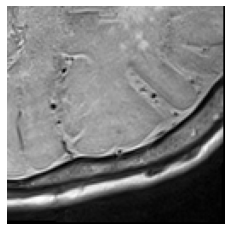

In [19]:
plt.imshow(xtrain[3,:,:,0,0], cmap='gray')
plt.axis('off');

In [14]:
len(xtrain)

1000

In [7]:
ret = get_blocks_within_volume(vol_metric, [volume1, volume3], blksz_3d,
                                                               stride_3d, patches_per_set_h,
                                                               n_lower=patches_per_set_l, seed=m,
                                                               shuffleP=blks_rand_shift_mode,
                                                               metric_operator=metric_operator,
                                                               nregions=nregions, return_bvm=True)

total blocks in the dataset before selection:  48
in get_top_block_locations, n_lower  & indx_ravel.shape:  100 (200,)
total time obtaining high blocks is using old approach was 0.02982187271118164 seconds
mean of whole volume, mean of selected volumes:  0.24182315 ,  0.27171491580943674
mean of whole volume, mean of selected volumes:  0.18501124 ,  0.20488915918726922


In [17]:
indexes = np.arange(20)
index = 0
batch_size = 5
idx = indexes[index*batch_size:(index+1)*batch_size]
print(idx)

[0 1 2 3 4]


In [18]:
a=np.zeros([10,2,3])

In [25]:
np.array([a[i] for i in idx]).shape

(5, 2, 3)

In [30]:
10821304320/1024/1024/1024

10.078125

In [1]:
import tifffile
from keras.models import model_from_json

from utils import *
from models import *

"""
key parameters (begin)
##############################################################################
"""
#combomatrix = [[8, 8, 8, 4, 4, 4, 9, 10000, 10000, 8, False]]
combomatrix = [128, 128, 64, 64, 64, 32, 9, 32, 0, 8, False]

In [7]:
script_path = os.getcwd()
image_dir = os.path.join(script_path, "../../ARIC/pd_wip/pd_nifti_final/pd_test")
imagefiles = [x for x in os.listdir(image_dir) if x.endswith('.gz')]

In [48]:
dirmodel = "train_unet3d_adam_batch20_1aug_proj0psm9_ssim_loss"
modelFileName = 'model_128x128x64x32(32)(0)x1_unet3d-[64x64x32]-psm9-8-4-2-0.5-F-F-batch12.h5'
jsonFileName = 'model_128x128x64x32(32)(0)x1_unet3d-[64x64x32]-psm9-8-4-2-0.5-F-F-batch12.json'
out_dir = dirmodel+"/result/"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)



In [ ]:
model = unet3d((combomatrix[0], combomatrix[1], combomatrix[2], 1),
                   out_ch=combomatrix[2],
                   start_ch=combomatrix[9],
                   depth=4,
                   inc_rate=2,
                   activation="relu",
                   dropout=0.5,
                   batchnorm=False,
                   maxpool=True,
                   upconv=False,
                   residual=False,
                   zdim=combomatrix[2],
                   true_unet=True)
model.load_weights(os.path.join(dirmodel, modelFileName))

In [10]:
image_name = imagefiles[0]
volume1,maxsi = load_tiff_volume_and_scale_si(image_dir, image_name,1,1,0,0,0,0,0) #
#volume1 = volume1.transpose(2,0,1)
#img = np.expand_dims(volume1,-1)
print(volume1.shape)


(320, 320, 128)
64


In [53]:
maxslc = volume1.shape[2]
inputMax = np.amax(volume1)
input_ch = combomatrix[2] 
print(input_ch)
zstride = input_ch // 2
stride_3d = combomatrix[3], combomatrix[4], combomatrix[5] 
volume_recon_ai = np.zeros([int(stride_3d[0] * np.ceil(volume1.shape[0] / stride_3d[0])),
                                int(stride_3d[1] * np.ceil(volume1.shape[1] / stride_3d[1])),
                                int(zstride * np.ceil(volume1.shape[2] / (zstride)))], dtype=np.float16)
volume1_shape_orig = volume1.shape
npadvoxs = tuple(np.subtract(volume_recon_ai.shape, volume1_shape_orig))
volume1p = np.pad(volume1, ((0, npadvoxs[0]), (0, npadvoxs[1]), (0, npadvoxs[2])), 'edge') #(320, 320, 128)
volume_s = np.zeros([volume1p.shape[0], volume1p.shape[1], input_ch], dtype=np.float16)
print(volume_recon_ai.shape)
print(volume1.shape)
print(volume_s.shape)
print(npadvoxs)
blk_layers = int(volume_recon_ai.shape[2] / zstride) # 128/32 = 4
# if we've expanded the matrix volume_recon_ai w.r.t. volume1 subtract 1 from the number of recon blocks
if volume_recon_ai.shape[2] != volume1p.shape[2]:
    blk_layers -= 1

slc_folding_total = volume_recon_ai.shape[2] - volume1p.shape[2]  # total additional slices we need to add to the stack to reconstruct on a block by block basis in the z direction
slc_folding_top = int(slc_folding_total // 2)  # additional slices to add to the top    of the volume
slc_folding_bottom = int(slc_folding_total - slc_folding_top)  # additional slices to add to the bottom of the volume
maxzposprocessed_volume1 = 0
batch_size_recon=16

64
(320, 320, 128)
(320, 320, 128)
(320, 320, 64)
(0, 0, 0)


In [ ]:
    debuglogic = False
    for iBlks in range(blk_layers):  # loop through reconstruction layers in the z direction
        print('#############################################')
        print('recon layer', iBlks + 1, 'of', blk_layers)
        blk_start = iBlks * zstride  # z (i.e. slice index) of current block being reconstructed
        if iBlks == 0:  # for uppermost block
            if slc_folding_top > 0:
                volume_s[:, :, 0:slc_folding_top] = np.flip(volume1p[:, :, 0:slc_folding_top],2)  # flip upper most slices and place at top of the initial block
            volume_s[:, :, slc_folding_top:] = volume1p[:, :, 0:blksz_3d[2] - slc_folding_top]  # place remaining true slices into the block
            maxzposprocessed_volume1 = zstride - slc_folding_top
            if debuglogic: print(' first blk', iBlks, 'maxzposprocessed_volume1', maxzposprocessed_volume1)
        elif iBlks == blk_layers - 1:  # for lowermost block
            volume_s[:, :, 0:input_ch - slc_folding_bottom] = volume1p[:, :,
                                                              -(input_ch - slc_folding_bottom):]
            if slc_folding_bottom > 0:
                volume_s[:, :, input_ch - slc_folding_bottom:] = np.flip(
                    volume1p[:, :, -slc_folding_bottom:], 2)
            if debuglogic: print(' last blk', iBlks, 'maxzposprocessed_volume1', volume1p.shape[2])
        else:  # central/middle blocks
            volume_s[:, :, :] = volume1p[:, :, maxzposprocessed_volume1:maxzposprocessed_volume1 + input_ch]
            maxzposprocessed_volume1 = maxzposprocessed_volume1 + zstride
            if debuglogic: print('central blk', iBlks, 'maxzposprocessed_volume1', maxzposprocessed_volume1)

        # print('max, min before getBlock: ', np.amax(volume_s), np.amin(volume_s))
        xtest = get_patches_2p5d(volume_s, blksz_3d[:2], stride_3d[:2])
        # print('max, min after getBlock: ', np.amax(xtest), np.min(xtest))
        xtest = np.expand_dims(xtest, axis=4)
        if debuglogic:
            newimage = np.copy(xtest)  # fast non gpu recon option for debugging code logic
        else:
            newimage = model.predict(xtest, batch_size=batch_size_recon, verbose=1)  # verbose=1
        #del xtest
        # print('iBlks, amax(newimage), amin(newimage), newimage.shape: ', iBlks, np.amax(newimage), np.amin(newimage), newimage.shape)
        imgshape = newimage.shape
        if debuglogic:
            dlimage = np.ones((volume1p.shape[0], volume1p.shape[1], input_ch)) * iBlks
        else:
            dlimage = np.zeros((volume1p.shape[0], volume1p.shape[1], input_ch))

        t = time.time()
        if debuglogic:
            pass
        else:
            if parallel_recon:
                # parallel (fast) computation
                num_cores = multiprocessing.cpu_count() - 2
                slice_positions = range(input_ch)
                print('parallel recon slices', slice_positions, '...')
                results = Parallel(n_jobs=num_cores)(
                    delayed(reconstruct_from_patches_2d_centerpixels)(newimage[:, :, :, iSlc, 0],
                                                                      [volume1p.shape[0],
                                                                       volume1p.shape[1]],
                                                                      (stride_3d[0], stride_3d[1])) for iSlc
                    in slice_positions)
                for i, value in enumerate(results):
                    dlimage[:, :, i] = np.copy(value)
            else:
                # sequential (slow) computation
                for i in range(input_ch):
                    print('serial recon slice', i + 1, 'of', input_ch)
                    dlimage[:, :, i] = reconstruct_from_patches_2d_centerpixels(newimage[:, :, :, i, 0],
                                                                                [volume1p.shape[0],
                                                                                 volume1p.shape[1]], (
                                                                                stride_3d[0], stride_3d[1]))
            del newimage
        elapsed = time.time() - t
        print('total time for tiling', input_ch, 'slices was', elapsed, 'seconds')

        if input_ch % 2 == 0:
            scale_per_slice = 1.0 / (zstride - 1)
            odd_input_ch = False
        else:
            scale_per_slice = 1.0 / zstride
            odd_input_ch = True

        zoffset = iBlks * zstride
        if iBlks == 0:  # uppermost block
            for i in range(zstride):
                volume_recon_ai[:, :, i] = dlimage[:, :,
                                           i]  # place uppermost half of block into the final volume without weighting
                if debuglogic: print('slice', i, 'scale', 1)
            if odd_input_ch:
                volume_recon_ai[:, :, zstride] = dlimage[:, :, zstride]
                if debuglogic: print('slice', zstride, 'scale', 1)
            for i in range(zstride):
                volume_recon_ai[:, :, (input_ch - 1 - i)] += dlimage[:, :,
                                                             input_ch - 1 - i] * i * scale_per_slice  # linearly weight with distance from block center
                if debuglogic: print('slice', (input_ch - 1 - i), 'scale', i * scale_per_slice)
        elif iBlks == blk_layers - 1:  # lowermost block
            for i in range(zstride):
                volume_recon_ai[:, :, zoffset + i] += dlimage[:, :, i] * i * scale_per_slice
                if debuglogic: print('slice', zoffset + i, 'scale', i * scale_per_slice)
            try:
                if odd_input_ch:
                    volume_recon_ai[:, :, zoffset + zstride] += dlimage[:, :, zstride]
                    if debuglogic: print('slice', zoffset + zstride, 'scale', 1)
            except:
                pass
            for i in range(zstride):
                try:
                    volume_recon_ai[:, :, iBlks * zstride + (input_ch - 1 - i)] = dlimage[:, :,
                                                                                  input_ch - 1 - i]
                    if debuglogic: print('slice', zoffset + (input_ch - 1 - i), 'scale', 1)
                except:
                    pass
        else:  # central blocks
            for i in range(zstride):
                if (zoffset + i) < maxslc:
                    volume_recon_ai[:, :, zoffset + i] += dlimage[:, :, i] * i * scale_per_slice
                    if debuglogic: print('slice', zoffset + i, 'scale', i * scale_per_slice)
            if odd_input_ch:
                volume_recon_ai[:, :, zoffset + zstride] += dlimage[:, :, zstride]
                if debuglogic: print('slice', zoffset + zstride, 'scale', 1)
            for i in range(zstride):
                if (zoffset + (input_ch - 1 - i)) < maxslc:
                    volume_recon_ai[:, :, zoffset + (input_ch - 1 - i)] += dlimage[:, :,
                                                                           input_ch - 1 - i] * i * scale_per_slice
                    if debuglogic: print('slice', zoffset + (input_ch - 1 - i), i * scale_per_slice)

    if np.sum(npadvoxs) > 0:  # crop to original input volume size
        if volume_recon_ai.shape[2] != volume1_shape_orig[2]:
            volume_recon_ai = volume_recon_ai[:volume_recon_ai.shape[0] - npadvoxs[0],
                              :volume_recon_ai.shape[1] - npadvoxs[1],
                              :volume_recon_ai.shape[2] - npadvoxs[2]]
        else:
            volume_recon_ai = volume_recon_ai[:volume_recon_ai.shape[0] - npadvoxs[0],
                              :volume_recon_ai.shape[1] - npadvoxs[1], :]

    # write reconstruction to multipage tiff stack
    volume_recon_ai = undo_reproject(volume_recon_ai, proj_direction)  # switch back to x,y,z order
    if unet_resnet_mode:
        volume1 = undo_reproject(volume1, proj_direction)  # switch back to x,y,z order

    if unet_resnet_mode:  # if in unet resnet mode add output of network to lower quality input
        print('data_airecon.shape, volume1.shape: ', volume_recon_ai.shape, volume1.shape)
        volume_recon_ai = volume_recon_ai + volume1
        volume_recon_ai[volume_recon_ai < 0] = 0  # replace negative values with zeros

    # save to disk
    ai_max = np.amax(volume_recon_ai)
    data_airecon = np.uint16(np.round(np.float(inputMax) / ai_max) * np.moveaxis(volume_recon_ai, -1,
                                                                                 0))  # move slices from 3rd dimension to 1st dimension
    
    #tifffile.imsave(reconFileName_final, data_airecon, compress=6)
    FileSave(data_airecon, out_dir+image_name)
    #del volume_recon_ai, volume1  # delete to save memory



#############################################
recon layer 1 of 4


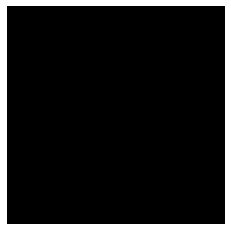

In [32]:
plt.imshow(data_airecon[100,:,:], cmap='gray')
plt.axis('off');

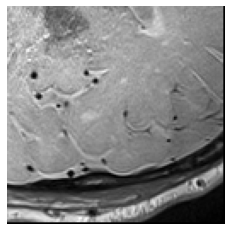

In [47]:

plt.imshow(xtest[15,:,:,1,:], cmap='gray')
plt.axis('off');

### 

In [49]:
data_airecon.shape

(128, 320, 320)

In [52]:
xtest.shape

(16, 128, 128, 64, 1)